# Image captioning model - Caption image

In [1]:
import torch
from transformers import GitForCausalLM, AutoProcessor, AutoConfig

base_checkpoint = 'microsoft/git-large-r-coco'
processor = AutoProcessor.from_pretrained(base_checkpoint)

config = AutoConfig.from_pretrained(base_checkpoint)
model_greedy = GitForCausalLM(config)
model_beam = GitForCausalLM(config)

In [2]:
# Check if running on GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load the pre-trained model
checkpoint_greedy = 'childrensimages-caption-20231108'
checkpoint_beam = 'childrensimages-caption-20231109'

if device == 'cuda':
    model_greedy.load_state_dict(torch.load(checkpoint_greedy))
    model_beam.load_state_dict(torch.load(checkpoint_beam))
elif device == 'cpu':
    model_greedy.load_state_dict(torch.load(checkpoint_greedy,map_location=torch.device('cpu')))
    model_beam.load_state_dict(torch.load(checkpoint_beam,map_location=torch.device('cpu')))

In [4]:
model_greedy.to(device)
model_beam.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-23): 24 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
      

# Inference

In [9]:
from PIL import Image

# Function to generate caption
def generate_captions(img_path):
    image = Image.open(img_path)
    new_size = (224, 224)
    # Resize the image
    resized_image = image.resize(new_size)
    
    # prepare image for the model
    inputs = processor(images=resized_image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    
    # Greedy search model
    generated_ids_greedy = model_greedy.generate(pixel_values=pixel_values, max_length=50)
    generated_caption_greedy = processor.batch_decode(generated_ids_greedy, skip_special_tokens=True)[0]
    
    # Beam search model
    generated_ids_beam = model_beam.generate(pixel_values=pixel_values, max_length=50)
    generated_caption_beam = processor.batch_decode(generated_ids_beam, skip_special_tokens=True)[0]
    
    return image, generated_caption_greedy, generated_caption_beam

In [10]:
img_root_path = '../Datasets/uploaded-images/'

In [16]:
import os 
# Define a list of images
imgs_validation = os.listdir(img_root_path)
#imgs_validation.remove('.ipynb_checkpoints')
imgs_captions = {}

In [17]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(len(imgs_validation)))

# Caption test images
for img in imgs_validation:
    image, caption_greedy, caption_beam = generate_caption(img_root_path + img)
    imgs_captions[img] = {'image':image, 'caption_greedy':caption_greedy, 'caption_beam': caption_beam}
    progress_bar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

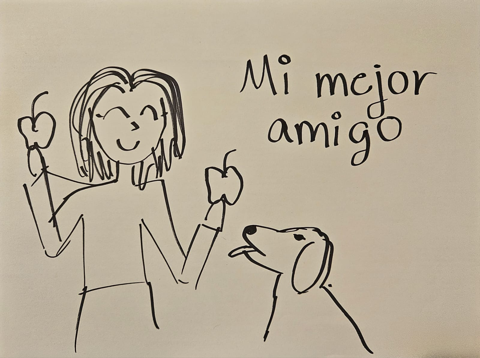

Generated caption Greedy:  drawing of a girl holding a dog and the title " mi mulano "
Generated caption Beam:  drawing of a girl and a dog with the caption " mizuo "




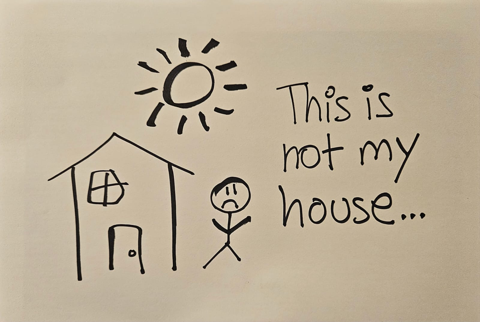

Generated caption Greedy:  drawing of a house and a sun with the title " this is not my house "
Generated caption Beam:  drawing of a spider and a house with the title " this is not my house "




In [18]:
for item in imgs_captions:
    image = imgs_captions[item]['image']
    width, height = image.size
    display(image.resize((int(0.3*width), int(0.3*height))))
    print('\033[1mGenerated caption Greedy: \033[0m',imgs_captions[item]['caption_greedy'])
    print('\033[1mGenerated caption Beam: \033[0m',imgs_captions[item]['caption_beam'])
    print('\n')

Save generated captions from both trained models.

## Format caption 
To serve as an input for ChatGPT API.

In [19]:
def clean_sentence(sentence):
    return sentence.replace('children\'s drawing of ','').replace('\'','\\\'').replace('\\\'','\'')

In [23]:
for item in imgs_captions:
    print(clean_sentence(imgs_captions[item]['caption_greedy']))
    print(clean_sentence(imgs_captions[item]['caption_beam']))

drawing of a girl holding a dog and the title " mi mulano "
drawing of a girl and a dog with the caption " mizuo "
drawing of a house and a sun with the title " this is not my house "
drawing of a spider and a house with the title " this is not my house "
